# Malaria DREAM challenge
## Subchallenge 1
The overall goal of the first Malaria DREAM Challenge is to predict Artemisinin (Art) drug resistance level of a test set of malaria parasites using their in vitro transcription data. The in vitro transcription dataset consists of 55 isolates, with transcription collected at two timepoints (6 and 24 hours post-invasion), in the absence or presence of an Art perturbation, for two biological replicates using a custom microarray at the Ferdig lab. Using these transcription datasets, the goal is to predict 50% inhibitory concentration values (IC50).

Goal: Predict the Artemisinin (Art) IC50 (drug concentration at which 50% of parasites die) of malaria isolates using in vitro transcriptomics data.

Scientific Rationale: Although IC50 measures are not representative of clinical resistance, insights into transcriptional changes that predict IC50 could clarify why we see a lack of IC50 shift in clinically resistant isolates, as well as perhaps a glimpse into the resistance mechanisms if clinical samples were to show an IC50 shift in the future.

## 0. Import required packages

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pl
from scipy.stats import randint as sp_randint
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from lmfit import Model
from collections import OrderedDict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn import neighbors
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import GenericUnivariateSelect
from sklearn.feature_selection import mutual_info_regression,f_regression
from scipy.stats import spearmanr
import seaborn as sns
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer

pl.style.use('seaborn')
pl.rc('font',family='Arial')

## 1. Read in and shape data

### 1.1. Read in data

In [2]:
train_data = pd.read_csv("SubCh1_TrainingData.csv")
test_data = pd.read_csv("SubCh1_TestData.csv")

In [3]:
train_data.head(10)

,Sample_Name,Isolate,Timepoint,Treatment,BioRep,MAL1.465720.465873.bc..rv..,MAL1.48287.48430....kr...can,MAL1.562126.562246.bc..r...,MAL1.59416.59687....kr...can,MAL1.616633.616682.......y.,...,PF3D7_1479200,PF3D7_1479400,PF3D7_1479500,PF3D7_1479600,PF3D7_1479700,PF3D7_1479800,PF3D7_1479900,PF3D7_1480000,PF3D7_1480100,DHA_IC50
0,isolate_01.24HR.DHA.BRep1,isolate_01,24HR,DHA,BRep1,0.008286,-0.959492,0.206468,-0.443936,0.453030,...,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528,2.177
1,isolate_01.24HR.DHA.BRep2,isolate_01,24HR,DHA,BRep2,-0.872028,-1.968558,-2.308563,-1.186611,0.508575,...,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568,2.177
2,isolate_01.24HR.UT.BRep1,isolate_01,24HR,UT,BRep1,0.039480,-1.291371,-0.946661,-0.538092,-1.778501,...,1.411557,-5.500522,-1.764229,-1.947208,-5.331037,-0.814417,-2.141285,-3.922684,-2.495169,2.177
3,isolate_01.24HR.UT.BRep2,isolate_01,24HR,UT,BRep2,0.125177,-1.462758,-1.888105,-0.828352,-1.410803,...,-0.659519,-5.011207,-0.559471,-2.266763,-5.289318,-2.949869,-2.206432,-4.324299,-1.735312,2.177
4,isolate_01.6HR.DHA.BRep1,isolate_01,6HR,DHA,BRep1,1.354956,-2.139128,-0.541696,-1.481881,-0.735798,...,-1.687048,-4.773306,-0.048847,-2.023727,-4.398358,-3.080500,-0.566545,-4.798190,-0.821690,2.177
5,isolate_01.6HR.DHA.BRep2,isolate_01,6HR,DHA,BRep2,-0.218074,-1.068870,-1.440467,-0.818662,-1.012132,...,-1.193494,0.062885,-0.309228,-1.563902,-3.632878,-2.245867,-1.462684,-4.701007,-1.618385,2.177
6,isolate_01.6HR.UT.BRep1,isolate_01,6HR,UT,BRep1,1.311350,-1.613464,-1.298663,-1.441343,-1.735923,...,-0.664116,-6.617301,2.161030,0.411185,-4.491597,-1.825722,-1.490832,-5.514126,-2.622619,2.177
7,isolate_01.6HR.UT.BRep2,isolate_01,6HR,UT,BRep2,0.997722,-1.553994,-1.960600,-1.424590,0.023609,...,-0.136047,-4.869960,-1.340846,-2.424770,-4.075909,-0.819760,-2.626978,-4.087643,-2.247185,2.177
8,isolate_02.24HR.DHA.BRep1,isolate_02,24HR,DHA,BRep1,-0.178971,-1.922426,-1.875015,-1.484605,-0.233600,...,0.024133,-2.215227,-1.957654,-2.188635,-4.424748,-2.986927,-1.722201,-3.995680,-0.902979,1.697
9,isolate_02.24HR.DHA.BRep2,isolate_02,24HR,DHA,BRep2,1.337421,-1.764941,-0.414673,-0.686910,0.291468,...,0.806314,-3.733712,-1.990368,-1.633418,-5.533077,-3.283316,-2.104227,-5.767710,-2.177930,1.697


### 1.2. One-hot encode Timepoints and Treatments; turn BioRep to integer

In [4]:
# train data:
train_data['Timepoint'] = [1 if i == '24HR' else 0 for i in train_data['Timepoint']]
train_data['Treatment'] = [1 if i == 'DHA' else 0 for i in train_data['Treatment']]
train_data['BioRep'] = [int(i[-1]) for i in train_data['BioRep']]

# test data:
test_data['Timepoint'] = [1 if i == '24HR' else 0 for i in test_data['Timepoint']]
test_data['Treatment'] = [1 if i == 'DHA' else 0 for i in test_data['Treatment']]
test_data['BioRep'] = [int(i[-1]) for i in test_data['BioRep']]

# generate list of gene names:
genes = list(train_data.drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis=1).columns)

### 1.3. Split into four data frames and combine into one

Each new df corresponds to a particular timepoint/treatment combination:

- A: 6hr untreated
- B: 24hr untreated
- C: 6hr treated
- D: 24hr treated

In [5]:
# split train data:
X_A = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_B = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_C = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
X_D = train_data[(train_data['Timepoint'] == 1)&(train_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Name','Isolate','Timepoint','Treatment','BioRep'], axis = 1)

# split test data:
Xt_A = test_data[(test_data['Timepoint'] == 0)&(test_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_B = test_data[(test_data['Timepoint'] == 1)&(test_data['Treatment'] == 0)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_C = test_data[(test_data['Timepoint'] == 0)&(test_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)
Xt_D = test_data[(test_data['Timepoint'] == 1)&(test_data['Treatment'] == 1)].drop(['DHA_IC50','Sample_Names','Isolate','Timepoint','Treatment','BioRep'], axis = 1)

# pull out target feature:
Y = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)]['DHA_IC50']

# extract biorep feature:
bioreps = train_data[(train_data['Timepoint'] == 0)&(train_data['Treatment'] == 0)]['BioRep']
bioreps_test = test_data[(test_data['Timepoint'] == 0)&(test_data['Treatment'] == 0)]['BioRep']

# rename train data columns:
X_A.columns = ['A' + str(i) for i in range(1,5541)]
X_B.columns = ['B' + str(i) for i in range(1,5541)]
X_C.columns = ['C' + str(i) for i in range(1,5541)]
X_D.columns = ['D' + str(i) for i in range(1,5541)]

# rename test data columns
Xt_A.columns = ['A' + str(i) for i in range(1,5541)]
Xt_B.columns = ['B' + str(i) for i in range(1,5541)]
Xt_C.columns = ['C' + str(i) for i in range(1,5541)]
Xt_D.columns = ['D' + str(i) for i in range(1,5541)]

# reset indices
X_A = X_A.reset_index().drop(['index'],axis=1)
X_B = X_B.reset_index().drop(['index'],axis=1)
X_C = X_C.reset_index().drop(['index'],axis=1)
X_D = X_D.reset_index().drop(['index'],axis=1)

Xt_A = Xt_A.reset_index().drop(['index'],axis=1)
Xt_B = Xt_B.reset_index().drop(['index'],axis=1)
Xt_C = Xt_C.reset_index().drop(['index'],axis=1)
Xt_D = Xt_D.reset_index().drop(['index'],axis=1)

# combine data frames:
X = pd.concat([X_A,X_B,X_C,X_D], axis=1)
Xt = pd.concat([Xt_A,Xt_B,Xt_C,Xt_D], axis=1)
X.head(10)

,A1,A2,A3,A4,A5,A6,A7,A8,A9,A10,...,D5531,D5532,D5533,D5534,D5535,D5536,D5537,D5538,D5539,D5540
0,1.311350,-1.613464,-1.298663,-1.441343,-1.735923,0.173112,2.466366,1.383979,-0.115130,0.287468,...,0.210607,-0.540993,-3.674097,-1.652979,-2.255490,-4.554757,-0.381422,-1.415857,-4.121011,-2.486528
1,0.997722,-1.553994,-1.960600,-1.424590,0.023609,0.420973,1.128427,0.722659,1.878123,-0.065159,...,-0.447109,0.450649,-4.464408,-0.977954,-2.012559,-4.538550,-2.333890,-2.342496,-4.774197,-1.794568
2,0.389508,-2.139782,-0.584985,-1.085373,0.803247,0.766617,1.701689,0.926101,1.600687,0.435633,...,-0.070151,0.024133,-2.215227,-1.957654,-2.188635,-4.424748,-2.986927,-1.722201,-3.995680,-0.902979
3,0.348560,-1.562540,-0.586732,-0.834661,1.096979,0.121817,1.623373,-0.654405,0.221121,0.998601,...,-1.288305,0.806314,-3.733712,-1.990368,-1.633418,-5.533077,-3.283316,-2.104227,-5.767710,-2.177930
4,0.138276,-1.612280,-1.362990,-1.360318,0.488124,0.365410,0.739845,-0.654702,2.170263,0.630418,...,0.279816,0.115002,-1.305902,-0.679212,-2.099512,-5.955507,-0.920594,-1.626372,-4.422711,-1.408485
5,-0.332565,-1.280348,-0.817751,-0.480521,-0.098970,0.112246,0.773993,-0.969944,1.117705,0.872166,...,0.375290,1.113241,-4.016287,-1.327287,-2.375500,-4.379304,-2.752906,-1.939162,-3.500963,-0.796143
6,-1.140942,-0.460872,0.588564,-1.214647,1.210955,1.336895,-0.857090,-1.884711,-0.001943,1.320737,...,0.666558,-2.016912,-4.682891,-0.254524,-2.668047,-6.573239,-3.264155,-0.671344,-5.312867,-2.248219
7,0.426584,-1.118851,-0.938263,-1.442067,0.747063,0.268388,1.062841,0.494635,0.866481,0.501923,...,-1.793459,-0.116719,-4.535173,-0.537190,-2.472669,-6.261742,-3.134708,-1.969545,-5.157691,-2.637917
8,0.037085,-1.488644,-1.838770,-1.066493,-1.305085,0.059484,2.128986,-0.527511,1.616871,0.235093,...,-0.478144,0.125283,-5.360958,-2.386122,-1.886257,-6.127057,-3.231487,-2.349583,-4.977880,-1.047555
9,-0.037537,-1.495531,-1.801568,-0.526676,-1.831555,0.494413,1.286978,-1.589983,1.060466,0.836018,...,1.213397,-1.032989,-8.298501,-0.080207,-2.335635,-4.606785,-2.849864,-2.028372,-3.179649,-2.205214


## 2. Feature engineering

### 2.1. Define Spearman metric

In [6]:
def spear_r(y_true, y_pred):
    return spearmanr(y_true, y_pred)[0]

### 2.2. Univariate f-regression, using top k features

In [7]:
def drop_univ(X_orig, Y, features):
    X = StandardScaler().fit_transform(X_orig)
    X_uni = GenericUnivariateSelect(f_regression,'k_best', param=features).fit_transform(X, Y.values.ravel())
    X_uni = pd.DataFrame(data = X_uni)

    return X_uni

### 2.3. Train SVR model with different numbers of features

In [8]:
# initialize empty lists
threshold = []
accuracy = []
mse = []
spearman = []
num_cols = []
cv = []
cv_spear = []

# loop over number of features
for j in np.arange(10,310,10):
    
    # univariate transform
    X_uni = drop_univ(X,Y,j)

    # set max features parameter to be the smaller of 50 and the number of features
    max_features = min(len(X_uni.columns),50)

    # split into training and testing data
    X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

    # train SVR model
    svr_model = SVR()
    svr_model.fit(X_train, Y_train.values.ravel())
    
    # predict with SVR model
    Y_pred = svr_model.predict(X_test) 
    
    # append values to lists
    threshold.append(j)
    accuracy.append(svr_model.score(X_test,Y_test))
    mse.append(mean_squared_error(Y_test, Y_pred))
    spearman.append(spearmanr(Y_test,Y_pred)[0])
    num_cols.append(len(X_uni.columns))
    cv.append(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5)))
    cv_spear.append(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), \
                                            cv=5,scoring=make_scorer(spear_r))))
    

# combine into data frame
results_unif = pd.DataFrame(list(zip(threshold,accuracy,mse,spearman,num_cols,cv,cv_spear)),\
                            columns =['threshold', 'accuracy','mse','spearman','num_cols','cv','cv_spear']) 

### 2.4. Plot performance vs. number of features

Mean squared error, spearman, and accuracy:

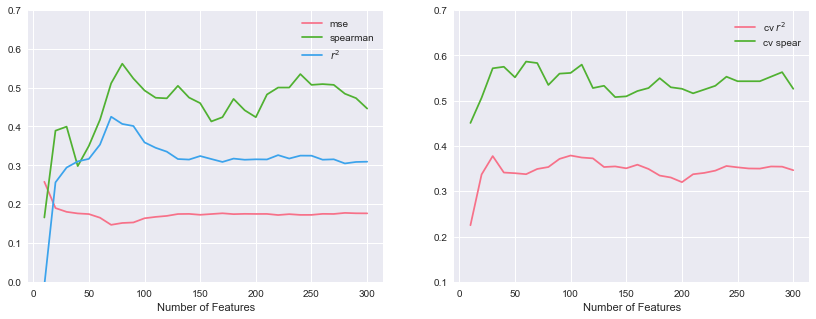

In [17]:
sns.set_palette("husl", 3)

fig, axes = pl.subplots(nrows=1, ncols=2, figsize=(14, 5))

axes[0].plot(results_unif['threshold'],results_unif['mse'])
axes[0].plot(results_unif['threshold'],results_unif['spearman'])
axes[0].plot(results_unif['threshold'],results_unif['accuracy'])
axes[0].legend(['mse', 'spearman',r'$r^2$'], loc=1)
axes[0].set_ylim(0,0.7)
axes[0].set_xlabel('Number of Features')

axes[1].plot(results_unif['threshold'],results_unif['cv'])
axes[1].plot(results_unif['threshold'],results_unif['cv_spear'])
axes[1].legend([r'cv $r^2$','cv spear'], loc=1)
axes[1].set_ylim(0.1,0.7)
axes[1].set_xlabel('Number of Features')

pl.show()

### 2.5. Look at top 70 features

In [20]:
# scale and transform data
X_s = StandardScaler().fit_transform(X)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

# extract importances
indices = transformer.get_support(indices=False)

# extract features
X_features = X.columns[indices].tolist()

In [21]:
print(X_features)

['A1040', 'A2793', 'B506', 'B1736', 'B2431', 'B4030', 'C44', 'C396', 'C419', 'C426', 'C511', 'C1103', 'C1315', 'C1531', 'C1559', 'C1702', 'C1751', 'C1786', 'C1820', 'C1904', 'C1949', 'C1970', 'C2035', 'C2097', 'C2260', 'C2287', 'C2567', 'C2681', 'C2711', 'C2714', 'C2718', 'C2905', 'C2931', 'C3078', 'C3238', 'C3257', 'C3291', 'C3357', 'C3361', 'C3436', 'C3531', 'C3577', 'C3702', 'C3985', 'C4292', 'C4607', 'C4743', 'C4792', 'C4861', 'C4982', 'C4987', 'C4988', 'C5019', 'C5058', 'C5240', 'C5245', 'C5444', 'D178', 'D960', 'D1103', 'D1107', 'D1181', 'D1901', 'D2061', 'D2241', 'D4447', 'D4866', 'D5025', 'D5183', 'D5520']


Most features come from the 6 hr treated sample (C), second to the 24 hr treated sample (D).

## 3. Optimize parameters for SVR model

### 3.1. Randomized search

In [22]:
# scale and transform data
X_s = StandardScaler().fit_transform(X)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

In [23]:
# split into train and test data
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

# define model
svr_model = SVR()

# define parameter ranges
param_dist = {"kernel": ['rbf', 'poly', 'sigmoid'],
              "C": [0.01,0.05,0.1, 0.5, 1, 5, 10, 50],
              "epsilon": [0.01, 0.05,  0.1, 0.015, 0.2,0.25],
              "gamma": [0.001, 0.01, 0.1, 'auto'],
              "degree": sp_randint(2,5)}

# define scorers
scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

# define random search paramters
n_iter_search = 100
random_search = RandomizedSearchCV(svr_model, param_distributions=param_dist,
                                   n_iter=n_iter_search, cv=5, iid=False, 
                                   scoring = scoring, refit = 'r2', return_train_score=True)

random_search.fit(X_train, Y_train.values.ravel())

# print best parameters
print(random_search.best_params_)

# extract top scores
scores = pd.DataFrame(random_search.cv_results_)
condition = scores['rank_test_spear_r'] == 1
df_1 = scores[condition].reset_index(drop = True)
print('spearman: ' + str(df_1.loc[0, 'mean_test_spear_r']))

{'epsilon': 0.01, 'gamma': 0.001, 'C': 10, 'kernel': 'sigmoid', 'degree': 2}
spearman: 0.7082447625496696


Look at top 10 best performing parameter sets

In [24]:
scores[['param_kernel','param_C','param_epsilon','param_gamma','param_degree','rank_test_spear_r']].sort_values(by='rank_test_spear_r').head(10)

,param_kernel,param_C,param_epsilon,param_gamma,param_degree,rank_test_spear_r
25,rbf,10,0.25,0.1,4,1
19,poly,5,0.015,0.01,3,2
39,rbf,5,0.05,0.1,3,3
93,rbf,10,0.05,0.1,2,3
89,poly,10,0.01,0.01,3,5
96,poly,10,0.015,0.01,3,5
42,rbf,50,0.1,0.001,3,7
6,rbf,1,0.015,0.1,4,8
21,rbf,0.05,0.1,0.1,3,9
40,rbf,0.5,0.015,0.1,3,10


### 3.2. Grid search

In [26]:
# split into train and test data
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=10)

# define model
svr_model = SVR()

# define parameter ranges
param_grid = {"kernel": ['rbf', 'poly'],
              "C": np.arange(0.5,10.5,0.5),
              "epsilon": np.arange(0.05,0.55,0.05),
              "gamma": [0.1, 'auto'],
              "degree": [2,3,4]}

# define scorers
scoring = {'r2': make_scorer(r2_score), 'spear_r': make_scorer(spear_r), 'mse': make_scorer(mean_squared_error)}

# define grid search paramters
grid_search = GridSearchCV(svr_model, param_grid=param_grid, cv=5, iid=False, 
                                   scoring = scoring, refit = 'r2', return_train_score=True)

grid_search.fit(X_train, Y_train.values.ravel())

# print best parameters
print(grid_search.best_params_)

# extract top scores
grid_scores = pd.DataFrame(grid_search.cv_results_)
condition = grid_scores['rank_test_spear_r'] == 1
df_2 = grid_scores[condition].reset_index(drop = True)
print('spearman: ' + str(df_2.loc[0, 'mean_test_spear_r']))

{'epsilon': 0.05, 'gamma': 'auto', 'C': 3.0, 'kernel': 'poly', 'degree': 3}
spearman: 0.739967600358922


### 3.3. Fit model using best parameters

In [28]:
# split into train and test
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=9)

# train model and predict
svr_model = SVR(kernel='rbf',epsilon=0.18, C=20,gamma=0.001)
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.1450967888945775
accuracy: 0.5701057116398662
spearman: 0.5139898870768772
cv score: 0.2684498948956698
cv spear: 0.7093963768213187


## 4. Final model to predict validation data set

In [30]:
# univariate f regression on train data
X_s = StandardScaler().fit_transform(X)
transformer = GenericUnivariateSelect(f_regression,'k_best', param=70)
X_uni = transformer.fit_transform(X_s, Y.values.ravel())
X_uni = pd.DataFrame(data = X_uni)

indices = transformer.get_support(indices=False)

X_features = X.columns[indices].tolist()
X_uni.columns = X_features

# filter features on validation data
Xs = StandardScaler().fit_transform(Xt)
X_predict = pd.DataFrame(data = Xs, columns = Xt.columns)
X_predict = X_predict[X_uni.columns]

In [31]:
# train model and predict new values
X_train, X_test , Y_train , Y_test = train_test_split(X_uni,Y,test_size=0.33,random_state=9)

svr_model = SVR(kernel='rbf',epsilon=0.18, C=20,gamma=0.001)
svr_model.fit(X_train, Y_train.values.ravel())
Y_pred = svr_model.predict(X_test) 
Y_pred_new = svr_model.predict(X_predict)

print('mse: ' + str(mean_squared_error(Y_test, Y_pred)))
print('accuracy: ' + str(svr_model.score(X_test,Y_test)))
print('spearman: ' + str(spearmanr(Y_test,Y_pred)[0]))
print('cv score: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5))))
print('cv spear: ' + str(np.mean(cross_val_score(svr_model, X_train, Y_train.values.ravel(), cv=5,scoring=make_scorer(spear_r)))))

mse: 0.1450967888945775
accuracy: 0.5701057116398662
spearman: 0.5139898870768772
cv score: 0.2684498948956698
cv spear: 0.7093963768213187


In [32]:
# average predictions over isolates
predictions = []
isolates = []
differences = []
for i in range(int(len(Y_pred_new)/2)):
    isolates.append('isolate_'+str(i+31))
    predictions.append((Y_pred_new[2*i]+Y_pred_new[2*i+1])/2.)
    differences.append(abs(Y_pred_new[2*i]-Y_pred_new[2*i+1]))

In [34]:
# export to tsv
predict = pd.DataFrame(list(zip(isolates,predictions)),columns=['Isolate','Predicted_IC50'])
predict.to_csv('SubCh1_Submission3.txt', index=None, header=True,sep='\t')
predict

,Isolate,Predicted_IC50
0,isolate_31,1.637450
1,isolate_32,1.608537
2,isolate_33,1.574949
3,isolate_34,1.839392
4,isolate_35,1.468358
5,isolate_36,1.335406
6,isolate_37,1.781434
7,isolate_38,1.676360
8,isolate_39,1.655502
9,isolate_40,1.319587
